# Using a Naive Bayes Model Generatively
We normally think of Naive Bayes as a classifier, but it can be used to generate data.  This notebook gives the technique.  The idea is that we will generate data that comes from a a Naive Bayes model, and then see how well we can fit a second Naive Bayes model to the data.  This lets us compare the model parameters for accuracy.

We'll use the coin flipping example that we started this unit with.  There are three binary random variables: 
* Flip: the outcome of a coin flip, either 0 (tails) or 1 (heads)
* Coin: which coin was chosen to flip, either 0 (coin 0) or 1 (coin 1)
* Hat: The colour of the hat worn when the chosen coin was flipped: either 0 (blue) or 1 (red)

For our task, we want to predict which coin was used, based on observing the outcome of the Flip and the colour of the Hat.

To use the model generatively, we'll specify model parameters, then use them to "sample" data that comes from the distribution modelled by the parameters.  Sampling is an important technique for advanced probabilistic models, and it will come up again later!

### Model Parameters 

The first parameter is the probability that coin 0 is chosen.  In terms of Naive Bayes classifiers, this is the distribution $P(Coin) = \{\theta_{c0}, \theta_{c1}\}$.

In [15]:
theta_c0 = 0.6
theta_c1 = 1 - theta_c0 

The strong assumption of conditional independence means that we need model parameters for:
* $P(Flip|Coin)$
* $P(Hat|Coin)$

We start with $P(Flip|Coin)$:
* $P(Flip=0|Coin=0) = \theta_{f00}$
* $P(Flip=1|Coin=0) = \theta_{f10} = 1 - \theta_{f00}$
* $P(Flip=0|Coin=1) = \theta_{f01}$
* $P(Flip=1|Coin=1) = \theta_{f11} = 1 - \theta_{f01}$

Here, because both variables are binary, the probability over outcomes for the same coin must sum to 1.  Likewise for the other pair.  

In [16]:
theta_f1_c0 = 0.1
theta_f0_c0 = 1 - theta_f1_c0

theta_f1_c1 = 0.9
theta_f0_c1 = 1 - theta_f1_c1

Now for $P(Hat|Coin)$:
* $P(Hat=0|Coin=0) = \theta_{h00}$
* $P(Hat=1|Coin=0) = \theta_{h10} = 1 - \theta_{h00}$
* $P(Hat=0|Coin=1) = \theta_{h01}$
* $P(Hat=1|Coin=1) = \theta_{h11} = 1 - \theta_{h01}$

In [17]:
theta_h1_c0 = 0.3
theta_h0_c0 = 1 - theta_h1_c0
theta_h1_c1 = 0.4
theta_h0_c1 = 1 - theta_h1_c1

### Generating random data from the model parameters
The technique here is specialized for our problem, but represents a pretty general concept.  If we know something about the model, we can ask for samples from it.  If we have a complex model, we can generate samples from it using a number of steps.

Because of the structure of the problem, the simplest distribution is $P(Coin)$.  Coin is a binary variable, and the probability distribution is a Bernoulli distribution with $\theta_{c1}$ controlling the outcome (not $\theta_{c0}$).  

The numpy module has implementations of many useful probability distribution functions, from which you can ask for samples.  It does not have a Bernoulli distribution, but that's okay.  We can use the Binomial distribution instead, and limit the number of outcomes to 1.  

The binomial() method takes two arguments.  The first is $N$, the number of trials, and the second is $\theta$, a probability for the success of each trial.  If we limit $N=1$, we can get a Bernoulli sample, which we can use to generate a choice of a value for which coin was used.

In [18]:
import numpy.random as nprand

coin_sample = nprand.binomial(1, theta_c1)
print('Chose a coin with probability', theta_c1, 'and observed', coin_sample)

Chose a coin with probability 0.4 and observed 0


We'll need more data than this.  

In [19]:
N = 1000

### Sampling from $P(Coin)$
The function binomial() can generate a numpy array of any size filled with outcomes 0 or 1, according to the given probability.  If the samples are generated with the given probability, we should see roughly $N\theta$ ones (1), and $N(1-\theta)$ zeroes (0).

In [20]:
Coins = nprand.binomial([1 for i in range (N)], theta_c1)
print('Ones -- Predicted:', int(N*theta_c1), ', Observed:', sum(Coins) )

Ones -- Predicted: 400 , Observed: 394


### Sampling from $P(Flip|Coin)$
This is equivalent to flipping the coin that was chosen.  It's also a Bertnoulli event, but the probability of a succes depends on which coin is chosen.  If we used coin 0, the probability of a head is $\theta_{f10}$, but if it's coin 1, we use $\theta_{f11}$.

In [21]:
flip1 = nprand.binomial(1, theta_f1_c0)
print('Flipped coin 0 and landed:', flip1)

flip2 = nprand.binomial(1, theta_f1_c1)
print('Flipped coin 1 and landed:', flip2)

Flipped coin 0 and landed: 0
Flipped coin 1 and landed: 1


What we really want is to generate a coin flip outcome for each one of the coin choices we generated earlier.  To do this, we'll go through the Coin choices one by one, and decide whether to use $\theta_{f10}$, or $\theta_{f11}$ based on the value of Coin.  

The simple function called bin_choose() decides which $\theta$ value to return, based on which coin was used.  We'll use it again to sample from $P(Hat|Coin)$

In [22]:
import numpy as np

def bin_choose(c, theta_0, theta_1):
    if c == 0:
        return theta_0
    else:
        return theta_1

Flips = np.array([nprand.binomial(1, bin_choose(c, theta_f1_c0, theta_f1_c1)) for c in Coins])

### Sampling from $P(Hat|Coin)$
According to the model, we need to sample a Hat depending on the Coin, too.  If this sounds weird, or not realistic,  that's probably true.  It;s what the model says, though, so we  have to do it.

In [23]:
Hats = np.array([nprand.binomial(1, bin_choose(c, theta_h1_c0, theta_h1_c1)) for c in Coins])

### Elementary data wrangling using Pandas
We've generated three lists of outcomes.  We'll make use of Pandas, a Python tool for organizing and working with datasets.  It's so popular that most Python package managers install it by default.  It is certainly almost always installed with Anaconda.

A dataframe is an object that behaves a little like a multi-dimentional list, or a 2D numpy array, but with far more flexibility and far more built-in tools.  Here's we'll just create a dataframe using one of the ways they can be generated.  First, a dictionary, and then the dataframe.

In [24]:
import pandas as pd

data = {'Flip' : [x for x in Flips], 
        'Hat'  : [x for x in Hats], 
        'Coin' : Coins}
coindata = pd.DataFrame(data)

One of Panda's basic data analysis tools is the describe() method:

In [25]:
coindata.describe()

,Flip,Hat,Coin
count,1000.000000,1000.000000,1000.000000
mean,0.409000,0.348000,0.394000
std,0.491895,0.476574,0.488879
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000


### Pandas data tools
Pandas has lots of other tools.  Here's a sampler.

Pandas can display a density plot, using another Python package called MatPlotLib.  This one is a little prettier than a table generated by describe().

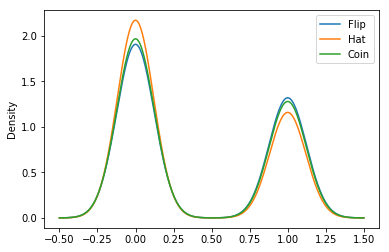

In [26]:
import matplotlib.pyplot as plt

coindata.plot.density()
plt.show()

# Pandas can also display a table of covariances using the method cov().  Don't let this slip past your attention.  Notice that the covariance between Hat and Flip is small.  This is what we should expect if Flip is conditionally independent of Hat, given Coin, as per our strong assumption.  

In [13]:
coindata.cov()

,Flip,Hat,Coin
Flip,0.241593,0.029685,0.187457
Hat,0.029685,0.222998,0.032382
Coin,0.187457,0.032382,0.238138


There's so many options and techniques, it's a little overwhelming.  Here's a covariance matrix that's colour-coded.  The dark colour is a little too dark to read, but it conveys information.

In [14]:
cov = coindata.cov()
cov.style.background_gradient().set_precision(3)

,Flip,Hat,Coin
Flip,0.242,0.0297,0.187
Hat,0.0297,0.223,0.0324
Coin,0.187,0.0324,0.238


Finally, let's write the datafile to disk, as a comma-separated file (csv).

In [15]:
coindata.to_csv('coindata.csv')